In [3]:
import sys
import random
sys.path.insert(0, "D:/IIT/DDP/DDP/B-SOID")

import pandas as pd
import matplotlib.pyplot as plt

from new_clustering import *
from joblib import Parallel, delayed

ImportError: Unable to import required dependencies:
numpy: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.7 from "D:\Applications\anaconda3\envs\ddp\python.exe"
  * The NumPy version is: "1.20.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed: The specified module could not be found.


In [2]:
with open("../../../data/strainwise_labels.sav", "rb") as f:
    feats, embeddings, labels = joblib.load(f)
strains = list(feats.keys())

# Checking classification accuracies for each strain
---

In [3]:
clf = RandomForestClassifier(n_jobs=-1)
def train_strainwise(strain, plot_dist=False):
    X, X_embed, lab = feats[strain], embeddings[strain], labels[strain][0]
    
    if plot_dist:
        _, counts = np.unique(lab, return_counts=True)
        plt.bar(range(len(counts)), counts)
        plt.show()

    model = clone(clf)
    scores = cross_validate(model, X, lab)
    return scores["test_score"]

In [4]:
strain_clf_scores = {strains[i]: train_strainwise(strains[i]) for i in tqdm(range(len(strains)))}

100%|██████████| 61/61 [20:44<00:00, 20.40s/it]


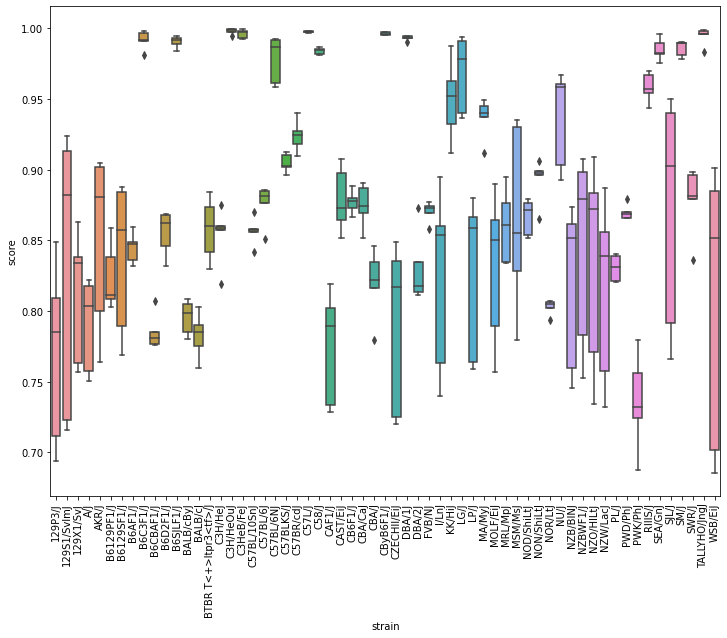

In [23]:
df = {"strain": [], "score": []}
for strain, scores in strain_clf_scores.items():
    for score in scores:
        df["strain"].append(strain)
        df["score"].append(score)
df = pd.DataFrame.from_dict(df)

import seaborn as sns
fig = plt.figure(figsize=(12,9))
sns.boxplot(x="strain", y="score", data=df)
plt.xticks(rotation=90)
plt.show()

# Use PCA for strainwise clustering

In [1]:
from BSOID.bsoid import BSOID
from sklearn.decomposition import PCA

bsoid = BSOID("../config/config.yaml")
feats = collect_strainwise_feats(bsoid.load_features(collect=False))

ModuleNotFoundError: No module named 'BSOID'

In [4]:
feats = collect_strainwise_feats(feats)
pca = PCA().fit(StandardScaler().fit_transform(np.vstack([d for _, d in feats.items()])))
print(f"Number of dimensions to retain 90\% of variance: {np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0] + 1}")

In [7]:
strainwise_pca = PCA(n_components=12).fit(StandardScaler().fit_transform(np.vstack([data for _, data in feats.items()])))

In [8]:
# import logging
# logging.basicConfig(level=logging.INFO)

# print(f"Processing {len(feats)} strains...")
# embedding, labels, pbar = {}, {}, tqdm(total=len(feats))
# for strain, data in feats.items():
#     logging.info(f"running for strain: {strain}")
#     embedding[strain] = strainwise_pca.transform(data)
#     labels[strain] = cluster_with_hdbscan(embedding[strain], STRAINWISE_CLUSTER_RNG, HDBSCAN_PARAMS)[2]
#     pbar.update(1)

def cluster_strainwise(strain, data):
    embedding = strainwise_pca.transform(data)
    labels = cluster_with_hdbscan(embedding, STRAINWISE_CLUSTER_RNG, {"prediction_data": True, "min_samples": 1, "core_dist_n_jobs": 1})
    return embedding, labels, strain

strains = list(feats.keys())
strainwise_clustering = Parallel(n_jobs=4)(delayed(cluster_strainwise)(strains[i], feats[strains[i]]) for i in tqdm(range(len(strains))))

100%|██████████| 58/58 [2:17:08<00:00, 141.88s/it]


In [18]:
embedding = {data[2]: data[0] for data in strainwise_clustering}
labels = {data[2]: data[1][2] for data in strainwise_clustering}
with open("../../../data/strainwise_labels_pca.sav", "wb") as f:
    joblib.dump([feats, embedding, labels, strainwise_pca], f)

[15,
 3,
 5,
 7,
 3,
 36,
 26,
 3,
 6,
 46,
 2,
 35,
 9,
 5,
 12,
 3,
 10,
 3,
 10,
 26,
 3,
 23,
 30,
 3,
 7,
 20,
 6,
 4,
 9,
 34,
 45,
 8,
 14,
 7,
 3,
 5,
 7,
 6,
 4,
 6,
 38,
 19,
 50,
 18,
 6,
 2,
 4,
 11,
 8,
 5,
 3,
 2,
 10,
 7,
 10,
 8,
 31,
 25]